In [1]:
import os
import pickle
import numpy as np
import nltk
import torch
import torchvision.transforms as transforms
import torch.utils.data as data
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd

from multiprocessing import cpu_count
from collections import Counter
from PIL import Image
from torch.nn.utils.rnn import pack_padded_sequence
from torchvision.models import resnet152

In [2]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
def resize_images(image_dir, output_dir, size):
  if not os.path.exists(output_dir):
    os.makedirs(output_dir)
  
  images = os.listdir(image_dir)
  num_images = len(images)
  for i, image in enumerate(images):
    with open(os.path.join(image_dir, image), 'r+b') as f:
      with Image.open(f) as img:
        img = img.resize(size, Image.ANTIALIAS)
        img.save(os.path.join(output_dir, image), img.format)
      if (i+1) % 1000 == 0:
        print("[{}/{}] Image Resized".format(i+1, num_images))

In [4]:
!pip install kaggle
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d kunalgupta2616/flickr-8k-images-with-captions
!unzip -q flickr-8k-images-with-captions.zip
image_dir = './Images'
output_dir = './resize'
image_size = [256, 256]
resize_images(image_dir, output_dir, image_size)

Saving kaggle.json to kaggle.json
 98% 1.01G/1.04G [00:12<00:00, 77.5MB/s]
100% 1.04G/1.04G [00:12<00:00, 86.8MB/s]
[1000/8091] Image Resized
[2000/8091] Image Resized
[3000/8091] Image Resized
[4000/8091] Image Resized
[5000/8091] Image Resized
[6000/8091] Image Resized
[7000/8091] Image Resized
[8000/8091] Image Resized


In [5]:
class Vocabulary(object):
  def __init__(self):
    self.word2idx = {}
    self.idx2word = {}
    self.idx = 0
    
  def add_word(self, word):
    if not word in self.word2idx:
      self.word2idx[word] = self.idx
      self.idx2word[self.idx] = word
      self.idx += 1
    
  def __call__(self, word):
    if not word in self.word2idx:
      return self.word2idx['<unk>']
    return self.word2idx[word]
  
  def __len__(self):
    return len(self.word2idx)

In [6]:
def build_vocab(df, threshold):
  counter = Counter()
  captions = df['caption']
  idx = 0

  for caption in captions:
    tokens = nltk.tokenize.word_tokenize(caption.lower())
    counter.update(tokens)

    if (idx+1) % 4000 == 0:
      print("[{}/{}] Caption Tokenized".format(idx+1, len(df)))
    idx+=1
  words = [word for word, cnt, in counter.items() if cnt>=threshold]

  vocab = Vocabulary()
  vocab.add_word('<pad>')
  vocab.add_word('<start>')
  vocab.add_word('<end>')
  vocab.add_word('<unk>')

  for w in words:
    vocab.add_word(w)
  
  return vocab

In [7]:
df = pd.read_csv('./captions.txt', sep=',')
vocab = build_vocab(df, 3)

with open('./vocab.pkl', 'wb') as f:
  pickle.dump(vocab, f)

[4000/40455] Caption Tokenized
[8000/40455] Caption Tokenized
[12000/40455] Caption Tokenized
[16000/40455] Caption Tokenized
[20000/40455] Caption Tokenized
[24000/40455] Caption Tokenized
[28000/40455] Caption Tokenized
[32000/40455] Caption Tokenized
[36000/40455] Caption Tokenized
[40000/40455] Caption Tokenized


In [8]:
class CocoDS(data.Dataset):
  def __init__(self, root, df, vocab, transform=None):
    self.root = root
    self.df = df
    self.vocab = vocab
    self.transform = transform

  def __getitem__(self, index):
    caption = self.df['caption'][index]
    img_id = self.df['image'][index]

    image = Image.open(os.path.join(self.root, img_id)).convert('RGB')
    if self.transform is not None:
      image = self.transform(image)
    
    tokens = nltk.tokenize.word_tokenize(caption.lower())
    caption = []
    caption.append(self.vocab('<start>'))
    caption.extend([self.vocab(token) for token in tokens])
    caption.append(self.vocab('<end>'))
    target = torch.Tensor(caption)
    return image, target

  def __len__(self):
    return len(self.df)

In [9]:
with open('./vocab.pkl', 'rb') as f:
  vocab = pickle.load(f)

transform = transforms.Compose([
  transforms.RandomCrop(224),
  transforms.RandomHorizontalFlip(),
  transforms.ToTensor(),
  transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

train_dataset = CocoDS('./resize', df=df, vocab=vocab, transform=transform)


In [10]:
def collate_fn(data):
  data.sort(key=lambda x: len(x[1]), reverse=True)
  images, captions = zip(*data)

  images = torch.stack(images, 0)

  lengths = [len(cap) for cap in captions]
  targets = torch.zeros(len(captions), max(lengths)).long()
  for i, cap in enumerate(captions):
    end = lengths[i]
    targets[i, :end] = cap[:end]
  
  return images, targets, lengths

In [11]:
if cpu_count() > 5:
  num_workers = cpu_count()
elif cpu_count() < 2:
  num_workers = 0
else:
  num_workers = 2

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=num_workers, collate_fn=collate_fn)

In [12]:
class EncoderCNN(nn.Module):
  def __init__(self):
    super().__init__()
    pretrained = resnet152(pretrained=True)
    layers = list(pretrained.children())[:-1]
    self.resnet = nn.Sequential(*layers)
    self.linear = nn.Linear(pretrained.fc.in_features, 256)
    self.bn = nn.BatchNorm1d(256, momentum=0.01)

  def forward(self, x):
    with torch.no_grad():
      features = self.resnet(x)
    features = features.view(features.size(0), -1)
    latent_vector = self.bn(self.linear(features))
    return latent_vector

In [13]:
class DecoderLSTM(nn.Module):
  def __init__(self, vocab_size):
    super().__init__()
    self.embed = nn.Embedding(vocab_size, 256)
    self.lstm = nn.LSTM(256, 512, 1, batch_first=True)
    self.linear = nn.Linear(512, vocab_size)

  def forward(self, features, captions, lengths):
    embeddings = self.embed(captions)
    embeddings = torch.cat((features.unsqueeze(1), embeddings), 1)
    packed = pack_padded_sequence(embeddings, lengths, batch_first=True)
    hiddens, _ = self.lstm(packed)
    outputs = self.linear(hiddens[0])
    return outputs

In [14]:
class EncoderDecoder(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        self.encoder = EncoderCNN()
        self.decoder = DecoderLSTM(vocab_size)
        
    def forward(self, images, features, captions, lengths):
        features = self.encoder(images)
        outputs = self.decoder(features, captions, lengths)
        return outputs

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

vocab_size = len(vocab)
model = EncoderDecoder(vocab_size=vocab_size).to(device)

criterion = nn.CrossEntropyLoss()
params = model.parameters()
optimizer = torch.optim.Adam(params, lr=0.001)

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/hub/checkpoints/resnet152-b121ed2d.pth


In [16]:
EPOCHS = 18
total_step = len(train_loader)

model.train()

for epoch in range(EPOCHS):
  for i, (images, captions, lengths) in enumerate(train_loader):
    images, captions = images.to(device), captions.to(device)
    targets = pack_padded_sequence(captions, lengths, batch_first=True)[0]
    optimizer.zero_grad()

    features = model.encoder(images)
    outputs = model.decoder(features, captions, lengths)
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()

    if (i+1) % 100 == 0:
      print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch, EPOCHS, i+1, total_step, loss.item()))

Epoch [0/18], Step [100/633], Loss: 3.6677
Epoch [0/18], Step [200/633], Loss: 3.0440
Epoch [0/18], Step [300/633], Loss: 3.1300
Epoch [0/18], Step [400/633], Loss: 3.1372
Epoch [0/18], Step [500/633], Loss: 3.0482
Epoch [0/18], Step [600/633], Loss: 2.9985
Epoch [1/18], Step [100/633], Loss: 2.5231
Epoch [1/18], Step [200/633], Loss: 2.6384
Epoch [1/18], Step [300/633], Loss: 2.6158
Epoch [1/18], Step [400/633], Loss: 2.6945
Epoch [1/18], Step [500/633], Loss: 2.5267
Epoch [1/18], Step [600/633], Loss: 2.4443
Epoch [2/18], Step [100/633], Loss: 2.2235
Epoch [2/18], Step [200/633], Loss: 2.2842
Epoch [2/18], Step [300/633], Loss: 2.3934
Epoch [2/18], Step [400/633], Loss: 2.2406
Epoch [2/18], Step [500/633], Loss: 2.4486
Epoch [2/18], Step [600/633], Loss: 2.2990
Epoch [3/18], Step [100/633], Loss: 2.0340
Epoch [3/18], Step [200/633], Loss: 2.1958
Epoch [3/18], Step [300/633], Loss: 2.1979
Epoch [3/18], Step [400/633], Loss: 2.0520
Epoch [3/18], Step [500/633], Loss: 2.0566
Epoch [3/18

In [17]:
torch.save(model.state_dict(), './2016312761_여혁수.pt')

In [18]:
def load_image(image_path):
  img = Image.open(image_path).convert('RGB')
  img = img.resize([224, 224], Image.LANCZOS)
  transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
  ])
  img = transform(img).unsqueeze(0)
  return img

In [19]:
def test(img):
  max_sequence_length = 20

  model.eval()
  word_ids = []

  with torch.no_grad():
    inputs = model.encoder(img).unsqueeze(1)
    states = None
    for i in range(max_sequence_length):
      hiddens, states = model.decoder.lstm(inputs, states)
      outputs = model.decoder.linear(hiddens.squeeze(1))
      _, predicted = outputs.max(1)
      word_ids.append(predicted)
      inputs = model.decoder.embed(predicted).unsqueeze(1)
    
    word_ids = torch.stack(word_ids, 1)
    word_ids = word_ids[0].detach().cpu().numpy()

  caption = []
  for id in word_ids:
    word = vocab.idx2word[id]
    caption.append(word)
    if word == '<end>':
      break

  caption = ' '.join(caption)
  return caption

img0
<start> a group of people are standing together on a sidewalk in front of a <unk> . <end>
img1
<start> a black and white dog playing with a brown dog in a field <end>
img2
<start> a man in a yellow shirt is sitting in a bus staring forward . <end>
img3
<start> a woman in a dress raises her arm over another person at a party . <end>
img4
<start> a soccer player in a red uniform is holding the ball . <end>
img5
<start> two dogs are playing together on a dry carpet . <end>
img6
<start> a woman holding a baby who is petting a dog . <end>
img7
<start> a football player in orange is being tackled by a oklahoma university in front of the crowd . <end>
img8
<start> a man dances with a wrestler while a woman in a white shirt watches from behind . <end>
img9
<start> a brown and white dog is jumping up in the air to catch a ball . <end>


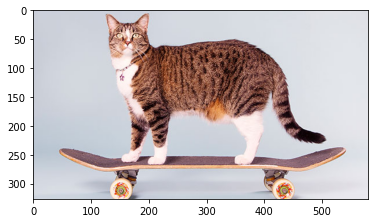

In [28]:
!unzip -q test_images.zip
for i in range(10):
  image_path = './test_images/randomimage'+str(i)+'.jpg'
  img = load_image(image_path).to(device)
  caption = test(img)
  print("img"+str(i))
  print(caption)
  image = Image.open(image_path)
  plt.imshow(np.asarray(image))